In [2]:
import ee
import geemap



In [3]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-anshulsg13')

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [9]:
# -------------------------------------------------------------
# 0) imports  (run once in the EE Code Editor or Colab)
# -------------------------------------------------------------
import ee, time


# -------------------------------------------------------------
# 1) helper functions
# -------------------------------------------------------------
def prepare_collection(year: int, geom: ee.Geometry) -> ee.ImageCollection:
    """
    Sentinel‑2 SR, 15 Jul → 15 Aug of the given year
    with CLOUDY_PIXEL_PERCENTAGE < 25 %.
    """
    return (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterDate(f'{year}-07-15', f'{year}-08-15')
              .filterBounds(geom)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 25)))


def lowest_cloud_composite(col: ee.ImageCollection,
                           aoi: ee.Geometry) -> ee.Image:
    """
    Sort by scene‑level cloudiness (ascending) and mosaic.
    Adds VALID / missing (UInt16) QA layers.
    """
    sel_bands = ['B2', 'B3', 'B4', 'B8', 'MSK_CLDPRB']

    # 1) clearest‑first mosaic
    raw = (col.sort('CLOUDY_PIXEL_PERCENTAGE')
             .mosaic()
             .select(sel_bands)
             .clip(aoi))

    # 2) cast each band to UInt16 while preserving original masks
    def to_uint16_keep_mask(name):
        b = raw.select(name)
        return b.toUint16().updateMask(b.mask())

    base = ee.Image([to_uint16_keep_mask(b) for b in sel_bands]) \
             .rename(sel_bands)

    # 3) QA layers
    valid   = base.mask().reduce(ee.Reducer.min()) \
                .rename('VALID').toUint16()
    missing = valid.Not().unmask(1).rename('missing').toUint16()

    return base.addBands([valid, missing])


def export_to_drive(img: ee.Image, name: str, coords: list[float], year: int,
                    folder: str = 'data') -> ee.batch.Task:
    desc   = f"{name}_{year}_clr_mosaic"
    region = ee.Geometry.Rectangle(coords, None, False)
    task = ee.batch.Export.image.toDrive(
        image          = img,
        description    = desc,
        folder         = f"{folder}/{name}/{year}",
        fileNamePrefix = desc,
        region         = region,
        scale          = 10,
        crs            = 'EPSG:4674',
        fileFormat     = 'GeoTIFF',
        maxPixels      = 1e10,
    )
    task.start()
    return task


def pixel_stats(img: ee.Image, geom: ee.Geometry) -> tuple[int, int]:
    """Return (total_pixels, missing_pixels) inside the AOI at 10 m."""
    total_px = (ee.Image(1).clip(geom)
                  .reduceRegion(ee.Reducer.count(), geom, 10,
                                maxPixels=1e9)
                  .values().get(0))

    missing_px = (img.select('missing')
                    .reduceRegion(ee.Reducer.sum(), geom, 10,
                                  maxPixels=1e9)
                    .values().get(0))

    return int(total_px.getInfo()), int(missing_px.getInfo())


# -------------------------------------------------------------
# 2) AOIs, years, driver
# -------------------------------------------------------------
aois = {
    'aoi1': {'coords': [-65, -10.5, -63, -9.5], 'name': 'location_1'},
    'aoi2': {'coords': [-69.0, -11.0, -68.0, -9.0], 'name': 'location_2'},
    'aoi3': {'coords': [-51.0, -4.5, -50.0, -2.5], 'name': 'location_3'},
}

years = [2022, 2023]
tasks = []

for a in aois.values():
    geom = ee.Geometry.Rectangle(a['coords'], None, False)
    for yr in years:
        col  = prepare_collection(yr, geom)
        comp = lowest_cloud_composite(col, geom)

        total_px, missing_px = pixel_stats(comp, geom)
        print(f"{a['name']} {yr} → missing: {missing_px:,} / "
              f"{total_px:,} ({missing_px/total_px*100:.4f} %)")

        tasks.append((a['name'], yr,
                      export_to_drive(comp, a['name'], a['coords'], yr)))

# -------------------------------------------------------------
# 3) monitor exports (optional)
# -------------------------------------------------------------
def print_status():
    for name, yr, t in tasks:
        st   = t.status()
        line = f"{name} {yr}: {st['state']}"
        if st.get('error_message'):
            line += f" (error: {st['error_message']})"
        print(line)

print("\nMonitoring export tasks…")
while any(t.active() for _, _, t in tasks):
    print_status()
    time.sleep(30)

print("\nFinal task statuses:")
print_status()


location_1 2022 → missing: 32,172 / 247,820,584 (0.0130 %)
location_1 2023 → missing: 32,172 / 247,820,584 (0.0130 %)
location_2 2022 → missing: 32,129 / 247,831,716 (0.0130 %)
location_2 2023 → missing: 32,129 / 247,831,716 (0.0130 %)
location_3 2022 → missing: 21,561,962 / 247,842,848 (8.6999 %)
location_3 2023 → missing: 30,775 / 247,842,848 (0.0124 %)

Monitoring export tasks…
location_1 2022: RUNNING
location_1 2023: RUNNING
location_2 2022: RUNNING
location_2 2023: RUNNING
location_3 2022: RUNNING
location_3 2023: RUNNING
location_1 2022: RUNNING
location_1 2023: RUNNING
location_2 2022: RUNNING
location_2 2023: RUNNING
location_3 2022: RUNNING
location_3 2023: RUNNING
location_1 2022: RUNNING
location_1 2023: RUNNING
location_2 2022: RUNNING
location_2 2023: RUNNING
location_3 2022: RUNNING
location_3 2023: RUNNING
location_1 2022: RUNNING
location_1 2023: RUNNING
location_2 2022: RUNNING
location_2 2023: RUNNING
location_3 2022: RUNNING
location_3 2023: RUNNING
location_1 2022:

In [ ]:
import ee
import geemap
import pandas as pd



# ---------------------------------------------------------------------------
# 1) AOIs & years
# ---------------------------------------------------------------------------
aois = {
    'aoi1': {
        'coords': [-65, -10.5, -64, -9.5],  # [west, south, east, north]
        'name': 'location_1'
    },
    'aoi2': {
        'coords': [-69.0, -11.0, -68.0, -10.0],
        'name': 'location_2'
    },
    'aoi3': {
        'coords': [-51.0, -4.5, -50.0, -3.5],
        'name': 'location_3'
    }
}

years = [2022, 2023]

# ---------------------------------------------------------------------------
# 2) Helpers
# ---------------------------------------------------------------------------

def add_ndvi(img: ee.Image) -> ee.Image:
    """Add an NDVI band (scaled –1..1 → –10000..10000, UInt16)."""
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndvi_scaled = ndvi.multiply(10000).toUint16()
    return img.addBands(ndvi_scaled)


def greenest_composite(col: ee.ImageCollection, aoi: ee.Geometry) -> ee.Image:
    """Return a greenest‑pixel composite with a per‑band *valid* mask and a
    binary *missing* band (1 = missing, 0 = good)."""
    sel_bands = ['B4', 'B3', 'B2', 'B8', 'NDVI', 'MSK_CLDPRB']

    comp = (
        col.qualityMosaic('NDVI')
           .select(sel_bands)
           .clip(aoi)
    )

    # ------------------------------
    # Build validity / missing mask
    # ------------------------------
    # 1) a stack of per‑band masks (same bands as above)
    band_masks = comp.mask()  # multi‑band mask image

    # 2) AND across bands → 1 where *all* bands present, 0 otherwise
    valid = band_masks.reduce(ee.Reducer.min()).rename('VALID').toUint8()

    # 3) Invert *and* unmask to 1 so reducers "see" the missing pixels
    missing = valid.Not().unmask(1).rename('missing')

    return comp.addBands([valid, missing])


def coverage_stats(img: ee.Image, geom: ee.Geometry) -> tuple[int, int]:
    """Return (total_pixels, missing_pixels)."""
    # Total is straightforward
    total_px = ee.Image(1).clip(geom).reduceRegion(
        ee.Reducer.count(), geom, 10, maxPixels=1e9
    ).values().get(0)

    # Missing is the *sum* of the binary band we created above
    missing_px = img.select('missing').reduceRegion(
        ee.Reducer.sum(), geom, 10, maxPixels=1e9
    ).values().get(0)

    return int(total_px.getInfo()), int(missing_px.getInfo())

# ---------------------------------------------------------------------------
# 3) Main driver
# ---------------------------------------------------------------------------

results = []

for aoi in aois.values():
    geom = ee.Geometry.Rectangle(aoi['coords'], 'EPSG:4674', False)

    for yr in years:
        print(f"\nProcessing {aoi['name']} – {yr} …")

        # 3.1) build collection
        col = (
            ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterDate(f'{yr}-07-15', f'{yr}-08-15')
              .filterBounds(geom)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 25))
              .map(add_ndvi)
        )

        if col.size().getInfo() == 0:
            print('  ✗ no imagery – skipping')
            continue

        # 3.2) composite + stats
        comp = greenest_composite(col, geom)
        total_px, missing_px = coverage_stats(comp, geom)
        covered = 100 * (1 - missing_px / total_px) if total_px else 0

        print(f"  Pixels: total = {total_px:,}  |  missing = {missing_px:,}  "
              f"({missing_px/total_px*100:.4f} %)  |  coverage = {covered:.2f} %")

        results.append({
            'AOI': aoi['name'],
            'Year': yr,
            'Total Pixels': total_px,
            'Missing Pixels': missing_px,
            'Coverage (%)': covered
        })

# ---------------------------------------------------------------------------
# 4) Summary table
# ---------------------------------------------------------------------------

df = pd.DataFrame(results)
print("\nNDVI composite coverage summary:\n", df)



Processing location_1 – 2022 …
  Pixels: total = 123,910,292  |  missing = 21,608  (0.0174 %)  |  coverage = 99.98 %

Processing location_1 – 2023 …
  Pixels: total = 123,910,292  |  missing = 21,608  (0.0174 %)  |  coverage = 99.98 %

Processing location_2 – 2022 …
  Pixels: total = 123,921,424  |  missing = 21,608  (0.0174 %)  |  coverage = 99.98 %

Processing location_2 – 2023 …
  Pixels: total = 123,921,424  |  missing = 21,608  (0.0174 %)  |  coverage = 99.98 %

Processing location_3 – 2022 …
  Pixels: total = 123,921,424  |  missing = 20,258  (0.0163 %)  |  coverage = 99.98 %

Processing location_3 – 2023 …
  Pixels: total = 123,921,424  |  missing = 20,254  (0.0163 %)  |  coverage = 99.98 %

NDVI composite coverage summary:
           AOI  Year  Total Pixels  Missing Pixels  Coverage (%)
0  location_1  2022     123910292           21608     99.982562
1  location_1  2023     123910292           21608     99.982562
2  location_2  2022     123921424           21608     99.982563
3

Processing Data

In [ ]:
# Function to analyze cloud and snow probability bands
def analyze_cloud_snow_prob(image, geometry):
    # Get all band names
    band_names = image.bandNames()

    # Check if the bands exist
    has_cloud_prob = band_names.contains('MSK_CLDPRB')
    has_snow_prob = band_names.contains('MSK_SNWPRB')

    # Print info about bands
    print(f"Available bands: {band_names.getInfo()}")
    print(f"Has MSK_CLDPRB band: {has_cloud_prob.getInfo()}")
    print(f"Has MSK_SNWPRB band: {has_snow_prob.getInfo()}")

    # If cloud probability band exists, analyze it
    if has_cloud_prob.getInfo():
        # Get histogram of cloud probability values
        cloud_histogram = image.select('MSK_CLDPRB').reduceRegion(
            reducer=ee.Reducer.frequencyHistogram(),
            geometry=geometry,
            scale=20,  # MSK_CLDPRB is at 20m resolution
            maxPixels=1e9,
            bestEffort=True
        ).get('MSK_CLDPRB').getInfo()

        if cloud_histogram:
            print('\nCloud probability (MSK_CLDPRB) value distribution:')
            print('-' * 50)
            print('Value | Count | Percentage')
            print('-' * 50)

            # Calculate total pixels
            total_cloud_pixels = sum(cloud_histogram.values())

            # Print sorted values
            for value_str in sorted(cloud_histogram.keys(), key=float):
                value = float(value_str)
                count = cloud_histogram[value_str]
                percentage = (count / total_cloud_pixels) * 100
                print(f"{value:5.0f} | {count:9.0f} | {percentage:8.2f}%")

            # Check cloud coverage at different thresholds
            thresholds = [20, 50, 80]
            for threshold in thresholds:
                cloud_mask = image.select('MSK_CLDPRB').gte(threshold)
                cloud_count = cloud_mask.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=geometry,
                    scale=20,
                    maxPixels=1e9
                ).get('MSK_CLDPRB').getInfo()

                percentage = (cloud_count / total_cloud_pixels) * 100 if total_cloud_pixels > 0 else 0
                print(f"Pixels with cloud probability ≥ {threshold}%: {cloud_count:0.0f} ({percentage:.2f}%)")
        else:
            print("No data found in MSK_CLDPRB histogram")

    # If snow probability band exists, analyze it
    if has_snow_prob.getInfo():
        # Get histogram of snow probability values
        snow_histogram = image.select('MSK_SNWPRB').reduceRegion(
            reducer=ee.Reducer.frequencyHistogram(),
            geometry=geometry,
            scale=20,  # MSK_SNWPRB is at 20m resolution
            maxPixels=1e9,
            bestEffort=True
        ).get('MSK_SNWPRB').getInfo()

        if snow_histogram:
            print('\nSnow probability (MSK_SNWPRB) value distribution:')
            print('-' * 50)
            print('Value | Count | Percentage')
            print('-' * 50)

            # Calculate total pixels
            total_snow_pixels = sum(snow_histogram.values())

            # Print sorted values
            for value_str in sorted(snow_histogram.keys(), key=float):
                value = float(value_str)
                count = snow_histogram[value_str]
                percentage = (count / total_snow_pixels) * 100
                print(f"{value:5.0f} | {count:9.0f} | {percentage:8.2f}%")

            # Check snow coverage at 50% threshold
            snow_mask = image.select('MSK_SNWPRB').gte(50)
            snow_count = snow_mask.reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geometry,
                scale=20,
                maxPixels=1e9
            ).get('MSK_SNWPRB').getInfo()

            percentage = (snow_count / total_snow_pixels) * 100 if total_snow_pixels > 0 else 0
            print(f"Pixels with snow probability ≥ 50%: {snow_count:0.0f} ({percentage:.2f}%)")
        else:
            print("No data found in MSK_SNWPRB histogram")

    return image

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from shapely.ops import unary_union

# -------------------------------
# AOI DEFINITIONS  (lon/lat, EPSG:4674)
# -------------------------------
aois = {
    'location_1': [-65,  -10.5, -64,  -9.5],   # [west, south, east, north]
    'location_2': [-69.0, -11.0, -68.0, -10.0],
    'location_3': [-51.0,  -4.5, -50.0,  -3.5]
}

# -------------------------------
# 1) LOAD YEARLY DEFORESTATION SHAPEFILE AND SPLIT
# -------------------------------
yearly_shp = '/content/drive/MyDrive/honors_thesis/data/raw/prodes/yearly_deforestation_biome.shp'
gdf_yearly = gpd.read_file(yearly_shp)
orig_crs   = gdf_yearly.crs              # should be EPSG:4674 (SIRGAS 2000)

gdf_yearly['image_date'] = pd.to_datetime(gdf_yearly['image_date'])
gdf_current     = gdf_yearly[gdf_yearly['image_date'].dt.year == 2023]        # Aug 2022–Jul 2023
gdf_past_events = gdf_yearly[gdf_yearly['image_date'].dt.year <  2023]        # ≤ 2022

print(f"Loaded {len(gdf_yearly)} yearly records: "
      f"{len(gdf_current)} current, {len(gdf_past_events)} past‑events")

# -------------------------------
# 2) LOAD ACCUMULATED ≤2007 SHAPEFILE
# -------------------------------
acc_shp = '/content/drive/MyDrive/honors_thesis/data/raw/prodes/accumulated_deforestation_2007/accumulated_deforestation_2007.shp'
gdf_acc = gpd.read_file(acc_shp)
print(f"Loaded {len(gdf_acc)} accumulated (≤2007) records")

# -------------------------------
# 3) CHOOSE A METRIC CRS AND REPROJECT EVERYTHING THERE
# -------------------------------
equal_area_crs = "EPSG:3857"   # Web‑Mercator: planar metres, good enough for AOI‑scale areas

gdf_current     = gdf_current.to_crs(equal_area_crs)
gdf_past_events = gdf_past_events.to_crs(equal_area_crs)
gdf_acc         = gdf_acc.to_crs(equal_area_crs)

# Build AOI polygons and project them, too
aoi_polys = {
    name: gpd.GeoSeries([box(*coords)], crs=orig_crs).to_crs(equal_area_crs).iloc[0]
    for name, coords in aois.items()
}

# -------------------------------
# 4) PER‑AOI ANALYSIS
# -------------------------------
results = []

for name, poly in aoi_polys.items():

    # Clip layers to AOI
    cur_clip  = gdf_current[gdf_current.intersects(poly)]
    past_clip = pd.concat(
        [
            gdf_past_events[gdf_past_events.intersects(poly)],
            gdf_acc[gdf_acc.intersects(poly)]
        ],
        ignore_index=True
    )

    # Union geometries to remove self‑overlap
    cur_union  = unary_union(cur_clip.geometry)   if not cur_clip.empty  else None
    past_union = unary_union(past_clip.geometry)  if not past_clip.empty else None

    # Trim unions to AOI boundary
    cur_geom  = cur_union.intersection(poly)  if cur_union  else None
    past_geom = past_union.intersection(poly) if past_union else None

    # Helper to measure km² (data already in metres)
    def area_km2(geom):
        return 0.0 if geom is None or geom.is_empty else geom.area / 1e6

    results.append({
        'location':      name,
        'current_km2':   area_km2(cur_geom),
        'past_km2':      area_km2(past_geom),
        'current_count': len(cur_clip),
        'past_count':    len(past_clip)
    })

# -------------------------------
# 5) DISPLAY SUMMARY
# -------------------------------
df = pd.DataFrame(results).set_index('location')

print("\n=== UNIQUE DEFORESTATION AREA PER AOI (km²) ===")
print(df[['current_km2', 'past_km2']]
      .to_string(float_format=lambda v: f"{v:.2f}"))

print("\n=== FEATURE COUNTS PER AOI ===")
print(df[['current_count', 'past_count']].to_string())


Loaded 718709 yearly records: 52452 current, 666257 past‑events
Loaded 206409 accumulated (≤2007) records

=== UNIQUE DEFORESTATION AREA PER AOI (km²) ===
            current_km2  past_km2
location                         
location_1       137.07   7831.79
location_2        76.87   3521.89
location_3       144.47   8051.57

=== FEATURE COUNTS PER AOI ===
            current_count  past_count
location                             
location_1            788       16365
location_2           1016       11829
location_3           1236       19228


In [ ]:
# 2) Define your AOIs in [west, south, east, north] (lon/lat on EPSG:4674).
aois = {
    'location_1': [-65,   -10.5, -64,  -9.5],
    'location_2': [-69.0, -11.0, -68.0, -10.0],
    'location_3': [-51.0,  -4.5, -50.0,  -3.5]
}

# 3) Use the built‑in pixel‑area image
pixel_area = ee.Image.pixelArea()

# 4) Loop over AOIs, reduce the pixelArea image over each rectangle,
#    forcing the reduction to occur in EPSG:4674 at a chosen scale.
for name, coords in aois.items():
    rect = ee.Geometry.Rectangle(coords)
    stats = pixel_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=rect,
        scale=1000,            # meter resolution of the calculation
        crs='EPSG:4674',       # force the reduction to use SIRGAS 2000
        maxPixels=1e12
    )
    # pixelArea’s band is called 'area'
    area_km2 = ee.Number(stats.get('area')).divide(1e6)
    print(f"{name}: {area_km2.getInfo():.2f} km²")


location_1: 12131.97 km²
location_2: 12099.68 km²
location_3: 12285.38 km²



Processing location_1...


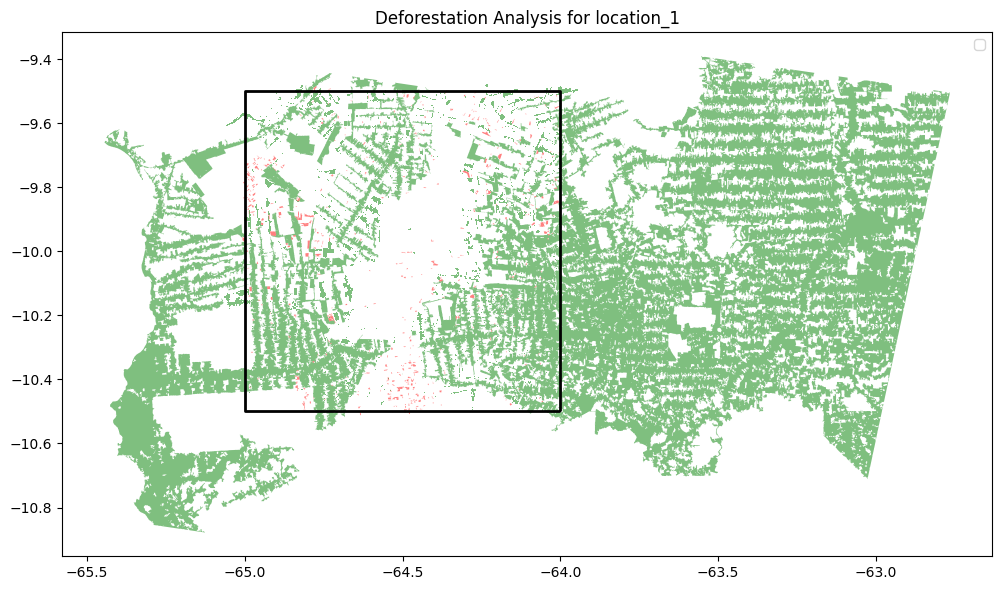

Recent deforestation polygons: 788
Accumulated deforestation polygons: 1057

Processing location_2...


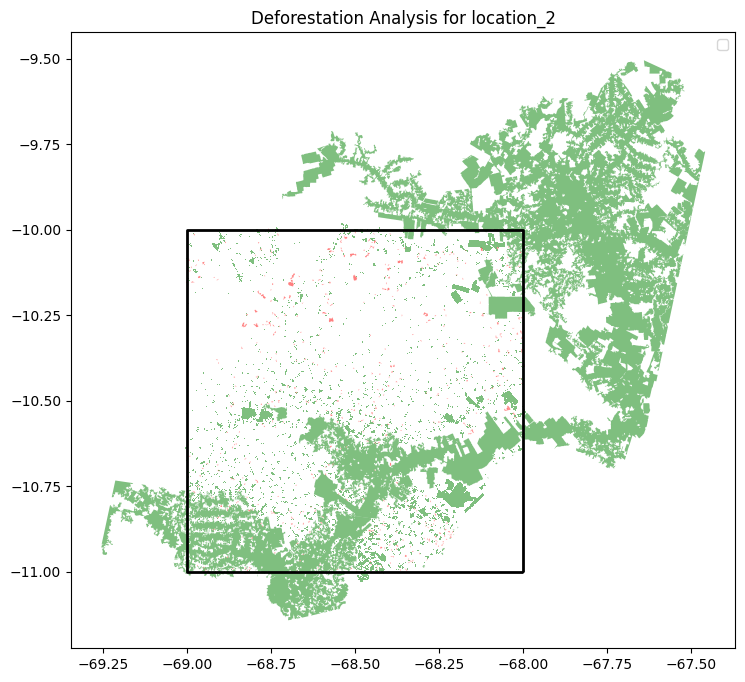

Recent deforestation polygons: 1016
Accumulated deforestation polygons: 3837

Processing location_3...


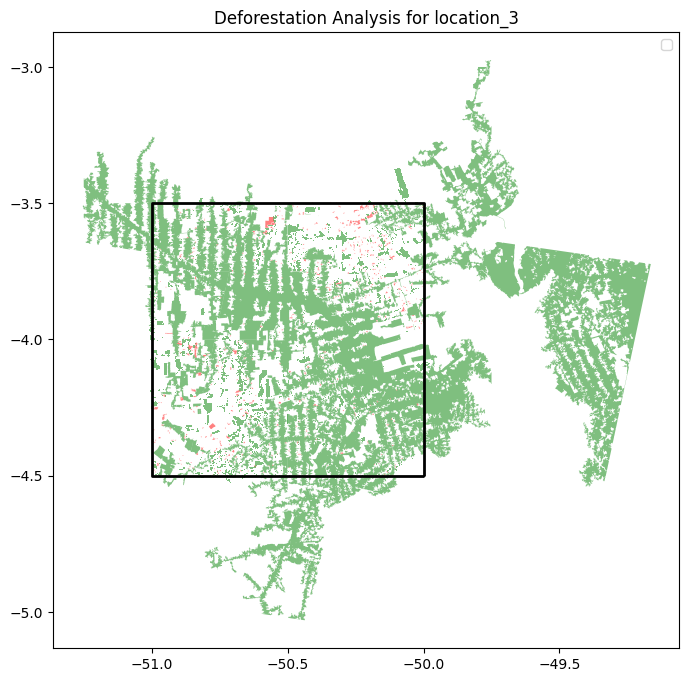

Recent deforestation polygons: 1236
Accumulated deforestation polygons: 1223
Could not add deforestation data from Earth Engine: Collection.loadTable: Asset 'projects/your-project/assets/accumulated_deforestation_2007' does not exist or doesn't allow this operation.
Continuing with AOIs only...


Map(center=[-8.222292798409725, -61.0798879492343], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
import ee
import geemap
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

# Initialize Earth Engine (if not already initialized)


# Define AOIs
aois = {
    'aoi1': {
        'coords': [-65, -10.5, -64, -9.5],  # [west, south, east, north]
        'name': 'location_1'
    },
    'aoi2': {
        'coords': [-69.0, -11.0, -68.0, -10.0],
        'name': 'location_2'
    },
    'aoi3': {
        'coords': [-51.0, -4.5, -50.0, -3.5],
        'name': 'location_3'
    }
}

# Load the shapefiles
deforestation_shapefile = '/content/drive/MyDrive/honors_thesis/data/raw/prodes/yearly_deforestation_biome.shp'
accumulated_shapefile = '/content/drive/MyDrive/honors_thesis/data/raw/prodes/accumulated_deforestation_2007/accumulated_deforestation_2007.shp'

# Read and filter the recent deforestation data
gdf_def = gpd.read_file(deforestation_shapefile)
gdf_def['image_date'] = pd.to_datetime(gdf_def['image_date'])
mask_def = (gdf_def['image_date'].dt.year == 2023)
filtered_gdf_def = gdf_def[mask_def]

# Read the accumulated deforestation data
gdf_acc = gpd.read_file(accumulated_shapefile)

# Ensure they have the same CRS
if filtered_gdf_def.crs != gdf_acc.crs:
    gdf_acc = gdf_acc.to_crs(filtered_gdf_def.crs)

# Define a function to create visualization for each AOI
def visualize_aoi_with_deforestation(aoi_key, aoi_info):
    """Create a visualization for one AOI with both deforestation datasets"""
    west, south, east, north = aoi_info['coords']
    aoi_name = aoi_info['name']

    # Create the AOI polygon
    from shapely.geometry import box
    aoi_polygon = box(west, south, east, north)
    aoi_gdf = gpd.GeoDataFrame({'geometry': [aoi_polygon]}, crs=filtered_gdf_def.crs)

    # Clip the deforestation data to the AOI
    def_clip = filtered_gdf_def[filtered_gdf_def.intersects(aoi_polygon)]
    acc_clip = gdf_acc[gdf_acc.intersects(aoi_polygon)]

    # Create visualization for this AOI
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the AOI boundary
    aoi_gdf.boundary.plot(ax=ax, color='black', linewidth=2)

    # Plot accumulated deforestation (up to 2007)
    if not acc_clip.empty:
        acc_clip.plot(ax=ax, color='green', alpha=0.5, label='Accumulated deforestation (up to 2007)')

    # Plot recent deforestation (2022-2023)
    if not def_clip.empty:
        def_clip.plot(ax=ax, color='red', alpha=0.5, label='Recent deforestation (2022-2023)')

    # Add title and legend
    ax.set_title(f"Deforestation Analysis for {aoi_name}")
    ax.legend()

    # Save the figure
    plt.savefig(f"deforestation_comparison_{aoi_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

    return def_clip, acc_clip

# Visualize each AOI separately
for key, aoi_info in aois.items():
    print(f"\nProcessing {aoi_info['name']}...")
    def_clip, acc_clip = visualize_aoi_with_deforestation(key, aoi_info)
    print(f"Recent deforestation polygons: {len(def_clip)}")
    print(f"Accumulated deforestation polygons: {len(acc_clip)}")

# Now create an Earth Engine visualization combining all AOIs
def create_ee_map_with_deforestation():
    """Create a Google Earth Engine map with all AOIs and deforestation data"""
    # Create a map
    m = geemap.Map()

    # Add each AOI to the map
    features = []
    for key, aoi in aois.items():
        coords = aoi['coords']
        name = aoi['name']

        # Create the rectangle geometry for each AOI
        geom = ee.Geometry.Rectangle(coords, 'EPSG:4674', False)

        # Create an EE Feature for styling
        feature = ee.Feature(geom, {'name': name})
        features.append(feature)

        # Add the feature layer to the map with boundary only
        m.addLayer(feature, {'color': 'black', 'fillColor': '00000000'}, name)

    # Create a FeatureCollection from all AOIs
    aoi_fc = ee.FeatureCollection(features)

    # Add deforestation datasets if available as Earth Engine assets
    # Note: This assumes you've uploaded the shapefiles to Earth Engine
    # If you haven't, you'll need to do that first through the Earth Engine Code Editor
    try:
        # Replace these with your actual asset IDs
        recent_def_asset = 'projects/your-project/assets/yearly_deforestation'
        accumulated_def_asset = 'projects/your-project/assets/accumulated_deforestation_2007'

        recent_def = ee.FeatureCollection(recent_def_asset)
        accumulated_def = ee.FeatureCollection(accumulated_def_asset)

        # Filter recent deforestation to match the filtering done in GeoPandas
        recent_def = recent_def.filter(ee.Filter.And(
            ee.Filter.eq('year', 2023),
            ee.Filter.eq('month', 7)
        ))

        # Add to map
        m.addLayer(accumulated_def, {'color': 'blue'}, 'Accumulated Deforestation (2007)')
        m.addLayer(recent_def, {'color': 'red'}, 'Recent Deforestation (2022-2023)')
    except Exception as e:
        print(f"Could not add deforestation data from Earth Engine: {e}")
        print("Continuing with AOIs only...")

    # Add a Sentinel-2 background
    sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate('2022-07-01', '2022-07-31') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .median()

    vis_params = {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 3000
    }

    m.addLayer(sentinel, vis_params, 'Sentinel-2 Background', False)

    # Center the map on all AOIs
    m.centerObject(aoi_fc, zoom=5)

    return m

# Create and display the Earth Engine map
ee_map = create_ee_map_with_deforestation()
ee_map

/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning: /content/drive/MyDrive/honors_thesis/data/raw/prodes/yearly_deforestation_biome.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Data columns: Index(['fid', 'state', 'path_row', 'main_class', 'class_name', 'sub_class',
       'def_cloud', 'julian_day', 'image_date', 'year', 'area_km', 'scene_id',
       'source', 'satellite', 'sensor', 'uuid', 'geometry'],
      dtype='object')
Year column data type: float64
Unique years: [2021. 2017. 2016. 2015. 2020. 2011. 2019. 2010. 2008. 2012. 2022. 2018.
 2023. 2013. 2009. 2014.]
Number of deforestation areas in 2023: 52452


<ipython-input-8-19a6057efb68>:60: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  aoi_patches = [mpatches.Patch(color='none', edgecolor=color, label=name)


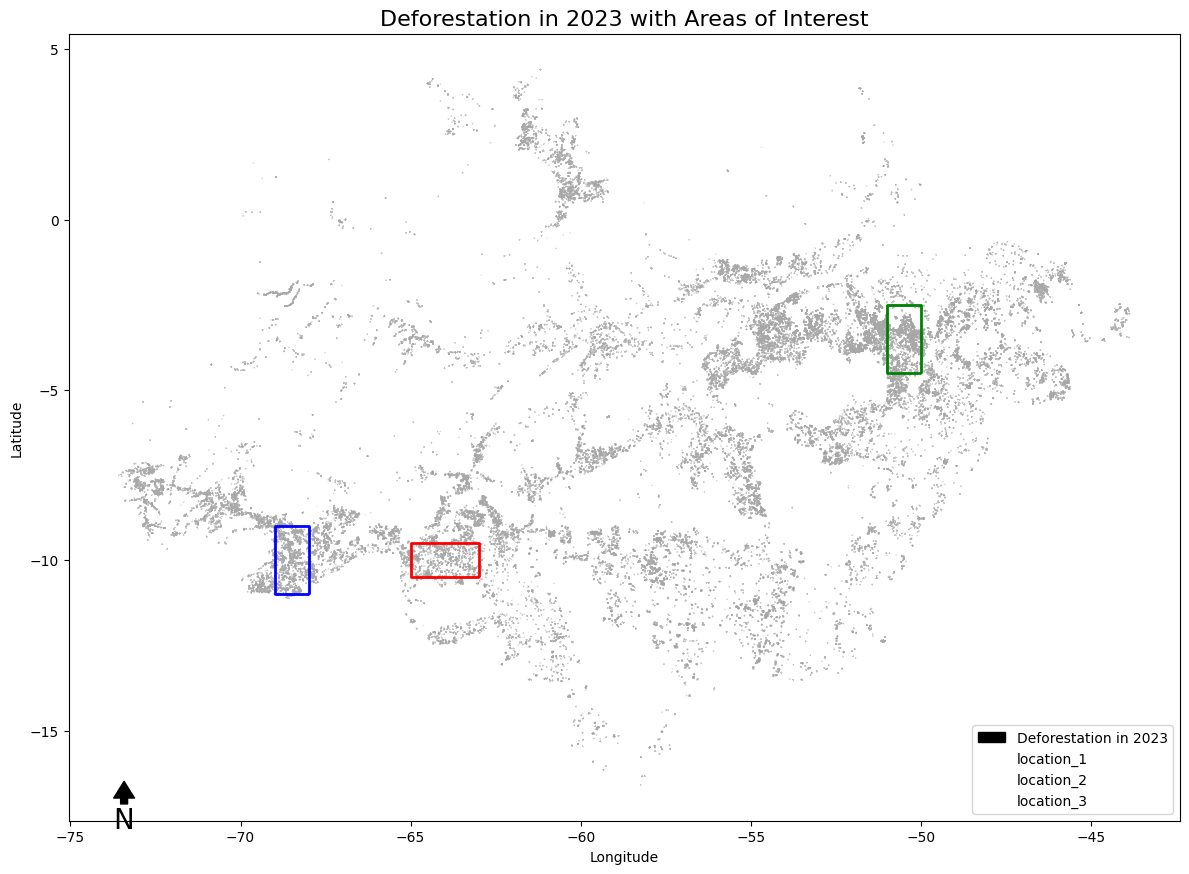

Total deforestation area in 2023: 7812.15 km


<ipython-input-8-19a6057efb68>:98: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  defor_in_aoi = gpd.overlay(deforestation_2023, aoi_gdf, how='intersection')


Deforestation in location_1 (2023): 191.63 km
Deforestation in location_2 (2023): 163.31 km
Deforestation in location_3 (2023): 310.65 km


<ipython-input-8-19a6057efb68>:98: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  defor_in_aoi = gpd.overlay(deforestation_2023, aoi_gdf, how='intersection')


In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import pandas as pd
from shapely.geometry import box

# Load the shapefile
deforestation = gpd.read_file('/content/drive/MyDrive/honors_thesis/data/raw/prodes/yearly_deforestation_biome.shp')

# Print the data to see what columns are available
print("Data columns:", deforestation.columns)
print("Year column data type:", deforestation['year'].dtype)
print("Unique years:", deforestation['year'].unique())

# Filter to only 2023 data
deforestation_2023 = deforestation[deforestation['year'] == 2023]

print(f"Number of deforestation areas in 2023: {len(deforestation_2023)}")

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the 2023 deforestation areas - now with black fill
deforestation_2023.plot(ax=ax, color='black', edgecolor='darkgray', alpha=0.7)

# Define the AOIs
aois = {
    'aoi1': {'coords': [-65, -10.5, -63, -9.5], 'name': 'location_1'},
    'aoi2': {'coords': [-69.0, -11.0, -68.0, -9.0], 'name': 'location_2'},
    'aoi3': {'coords': [-51.0, -4.5, -50.0, -2.5], 'name': 'location_3'},
}

# Create GeoDataFrame for the AOIs
aoi_geometries = []
aoi_names = []

for aoi_id, aoi_info in aois.items():
    coords = aoi_info['coords']
    west, south, east, north = coords
    aoi_geom = box(west, south, east, north)
    aoi_geometries.append(aoi_geom)
    aoi_names.append(aoi_info['name'])

aoi_gdf = gpd.GeoDataFrame({'name': aoi_names, 'geometry': aoi_geometries},
                          crs=deforestation_2023.crs)

# Plot AOIs with different colors
colors = ['red', 'blue', 'green', 'yellow']
for i, (idx, row) in enumerate(aoi_gdf.iterrows()):
    aoi_gdf.iloc[[i]].plot(ax=ax, color='none', edgecolor=colors[i], linewidth=2)
    # Add a label at the center of each AOI
    # centroid = row.geometry.centroid
    # ax.text(centroid.x, centroid.y, row['name'],
    #         ha='center', va='center', fontsize=10,
    #         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Create a legend that matches the visualization
black_patch = mpatches.Patch(color='black', label='Deforestation in 2023')
aoi_patches = [mpatches.Patch(color='none', edgecolor=color, label=name)
              for color, name in zip(colors, aoi_names)]
all_patches = [black_patch] + aoi_patches
ax.legend(handles=all_patches, loc='lower right')

# Add a title and labels
plt.title('Deforestation in 2023 with Areas of Interest', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a north arrow
x, y, arrow_length = 0.05, 0.05, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# Save and show the map
plt.tight_layout()
plt.savefig('deforestation_2023_with_aois_map.png', dpi=300, bbox_inches='tight')
plt.show()

# Print some statistics about the 2023 deforestation
if 'area_km' in deforestation_2023.columns:
    total_area = deforestation_2023['area_km'].sum()
    print(f"Total deforestation area in 2023: {total_area:.2f} km")


# Calculate deforestation within each AOI
for aoi_id, aoi_info in aois.items():
    coords = aoi_info['coords']
    west, south, east, north = coords
    aoi_box = box(west, south, east, north)

    # Create GeoDataFrame for the AOI
    aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_box], crs=deforestation_2023.crs)

    # Find deforestation within this AOI
    defor_in_aoi = gpd.overlay(deforestation_2023, aoi_gdf, how='intersection')

    # Calculate area
    if 'area_km' in defor_in_aoi.columns:
        aoi_area = defor_in_aoi['area_km'].sum()

    print(f"Deforestation in {aoi_info['name']} (2023): {aoi_area:.2f} km")

In [ ]:
[-65, -10.5, -64, -9.5],
[-55, -4.5, -52, -1.5]

In [ ]:
deforestation_shapefile = '/content/drive/MyDrive/honors_thesis/data/raw/prodes/yearly_deforestation_biome.shp'
gdf = gpd.read_file(deforestation_shapefile)

# Print the column names
print("Columns in the shapefile:")
print(gdf.columns)

Columns in the shapefile:
Index(['fid', 'state', 'path_row', 'main_class', 'class_name', 'sub_class',
       'def_cloud', 'julian_day', 'image_date', 'year', 'area_km', 'scene_id',
       'source', 'satellite', 'sensor', 'uuid', 'geometry'],
      dtype='object')


In [ ]:
!apt-get update && apt-get install -y gdal-bin libgdal-dev
!pip install rasterio

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [73.0 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,832 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Package

/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning: /content/drive/MyDrive/honors_thesis/data/raw/prodes/yearly_deforestation_biome.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Data columns: Index(['fid', 'state', 'path_row', 'main_class', 'class_name', 'sub_class',
       'def_cloud', 'julian_day', 'image_date', 'year', 'area_km', 'scene_id',
       'source', 'satellite', 'sensor', 'uuid', 'geometry'],
      dtype='object')
Year column data type: float64
Unique years: [2021. 2017. 2016. 2015. 2020. 2011. 2019. 2010. 2008. 2012. 2022. 2018.
 2023. 2013. 2009. 2014.]


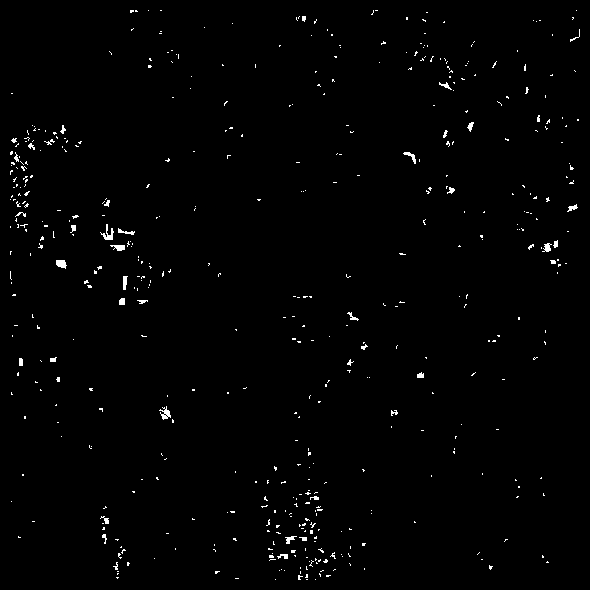

In [ ]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.transform import from_origin
from shapely.geometry import box
import matplotlib.pyplot as plt

deforestation = gpd.read_file('/content/drive/MyDrive/honors_thesis/data/raw/prodes/yearly_deforestation_biome.shp')

# Print the data to see what columns are available
print("Data columns:", deforestation.columns)
print("Year column data type:", deforestation['year'].dtype)
print("Unique years:", deforestation['year'].unique())

# Filter to only 2023 data
deforestation_2023 = deforestation[deforestation['year'] == 2023]

# ── 1.  Bounding box (west, south, east, north) ──────────────────────────────
bbox_coords = [-65, -10.5, -64, -9.5]
west, south, east, north = bbox_coords
bbox = box(west, south, east, north)

# ── 2.  Clip 2023 polygons to the box ────────────────────────────────────────
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs=deforestation_2023.crs)
defor_clip = gpd.clip(deforestation_2023, bbox_gdf)

# ── 3.  Decide pixel size and raster grid ────────────────────────────────────
#     0.001° ≈ 111 m at the equator; tweak if you want finer / coarser output
pixel_size = 0.001
width  = int(np.ceil((east  - west ) / pixel_size))
height = int(np.ceil((north - south) / pixel_size))
transform = from_origin(west, north, pixel_size, pixel_size)  # x‑res, y‑res

# ── 4.  Rasterize: 1 = deforestation, 0 = background ─────────────────────────
mask = features.rasterize(
    [(geom, 1) for geom in defor_clip.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# ── 5.  Display & optionally save ────────────────────────────────────────────
plt.figure(figsize=(6, 6), facecolor='black')
plt.imshow(mask, cmap='gray', interpolation='nearest', origin='upper')
#plt.title('2023 Deforestation Mask\n(-65, -10.5) → (-64, -9.5)', color='white')
plt.axis('off')
plt.tight_layout()
plt.savefig('deforestation_mask_2023_bbox.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
